# MAT388E HOMEWORK #2 
# Uzay Karadağ | 090200738
---

# Question 1

For this question use the World Bank Data for Turkey for the following indicators. Use [wbgapi](https://pypi.org/project/wbgapi/) for getting the data.

* [Literacy rate, adult female (SE.ADT.LITR.FE.ZS)](https://data.worldbank.org/indicator/SE.ADT.LITR.FE.ZS)
* [Labor force, female (SL.TLF.TOTL.FE.ZS)](https://data.worldbank.org/indicator/SL.TLF.TOTL.FE.ZS)
* [Poverty headcount ratio at national poverty lines (SI.POV.NAHC)](https://data.worldbank.org/indicator/SI.POV.NAHC)
* [Current health expenditure per capita (SH.XPD.CHEX.PC.CD)](https://data.worldbank.org/indicator/SH.XPD.CHEX.PC.CD)
* [GDP per capita (NY.GDP.PCAP.CD)](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD)
* [Mortality rate, under-5 (SH.DYN.MORT)](https://data.worldbank.org/indicator/SH.DYN.MORT)


Using the [statsmodels](https://www.statsmodels.org/stable/index.html) library write the best linear regression model using child mortality as the dependent variable while the rest are considered as independent variables. Pay particular attention to the fact that the order of the variables put into the model significantly impacts the performance of the model. Choose the best model by considering

* with the minimum number of variables and their interactions,
* with the optimal ordering of the independent variables and their interactions,
* $R^2$-score of the model,
* statistical significance of the model coefficients,
* ANOVA analysis of the model.


In [38]:
import wbgapi as wb
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
def get_data_wb(ticker, country_code = 'TUR'):
    tmp = pd.DataFrame(list(wb.data.fetch(ticker)))
    data = tmp[['time', 'value']][tmp['economy'] == country_code]
    return data

In [20]:
lit_rate = get_data_wb('SE.ADT.LITR.FE.ZS')
labor_force = get_data_wb('SL.TLF.TOTL.FE.ZS')
poverty_hcr = get_data_wb('SI.POV.NAHC')
health_exp = get_data_wb('SH.XPD.CHEX.PC.CD')
gdp_pc = get_data_wb('NY.GDP.PCAP.CD')
mortality = get_data_wb('SH.DYN.MORT')

In [42]:
independent_datasets = [lit_rate, labor_force, poverty_hcr, health_exp, gdp_pc]
independent_dataset_names = ['Literacy Rates', 'Labor Force', 'Poverty', 'Health Expenditure', 'GDP Per Capita']

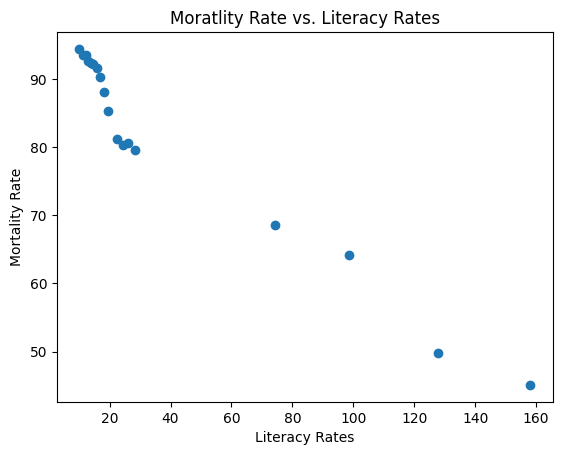

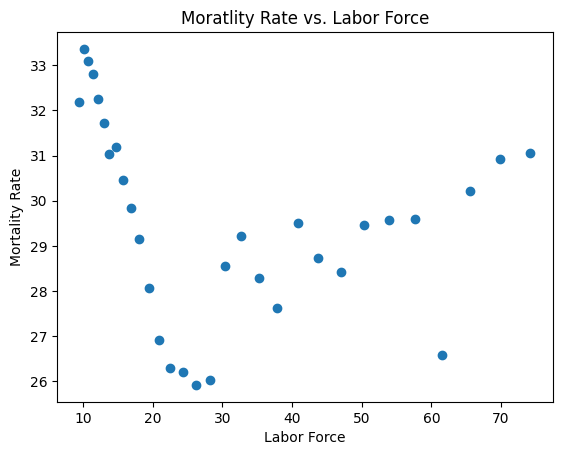

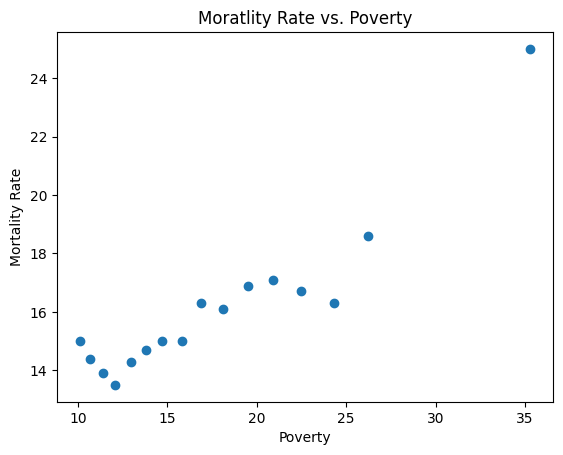

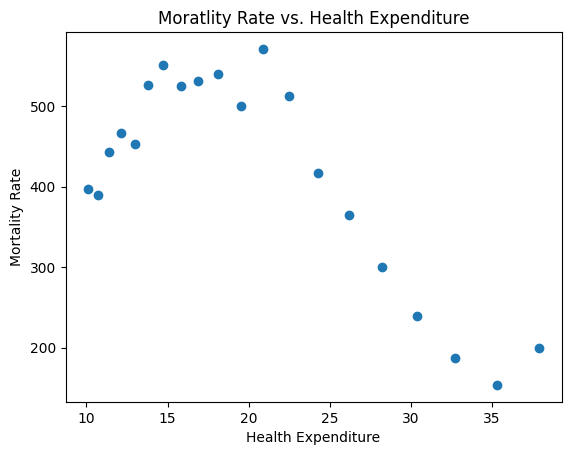

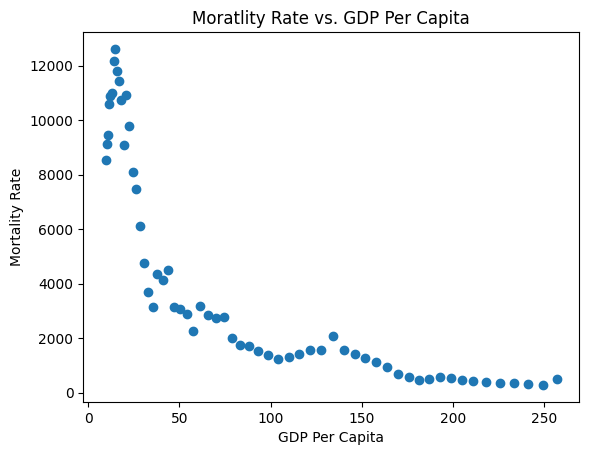

In [45]:
for dataset, name in zip(independent_datasets, independent_dataset_names):
    df = mortality.set_index('time').join(dataset.set_index('time'), lsuffix='left', rsuffix='right')
    plt.xlabel(name)
    plt.ylabel('Mortality Rate')
    plt.title('Moratlity Rate vs. {}'.format(name)) 
    plt.scatter(df['valueleft'], df['valueright'])
    plt.show()

After the first glance at the scatter plots, the relationship between the independent variables and the dependent variables does not seem to be linear at all, aside from of course the literacy rate being the predictor of mortality rate with an inverse relation. Let's build a DataFrame where the index is the time and the columns contain our dependent and independent variables, to further investigate and build our LR model.

In [81]:
data = mortality.rename(columns={'value': 'mortality_rate'})
data

,time,mortality_rate
1116,YR2021,NaN
1117,YR2020,9.5
1118,YR2019,10.1
1119,YR2018,10.7
1120,YR2017,11.4
...,...,...
1173,YR1964,225.7
1174,YR1963,233.5
1175,YR1962,241.4
1176,YR1961,249.3


In [82]:
col_names  = [name.lower().replace(' ', '_') for name in independent_dataset_names]
for col, dataset in zip(col_names, independent_datasets):
    data[col] = dataset['value']
data.drop(columns='time')

,mortality_rate,literacy_rates,labor_force,poverty,health_expenditure,gdp_per_capita
1116,NaN,NaN,32.470214,NaN,NaN,9586.612450
1117,9.5,NaN,32.175606,NaN,NaN,8536.433320
1118,10.1,94.424042,33.360649,15.0,396.466827,9121.515167
1119,10.7,NaN,33.089766,14.4,389.865570,9454.348443
1120,11.4,93.498268,32.799757,13.9,442.617615,10589.667725
...,...,...,...,...,...,...
1173,225.7,NaN,NaN,NaN,NaN,369.583469
1174,233.5,NaN,NaN,NaN,NaN,350.662985
1175,241.4,NaN,NaN,NaN,NaN,309.446624
1176,249.3,NaN,NaN,NaN,NaN,283.828284


In [83]:
data.corr().style.background_gradient(cmap='bone_r').set_precision(3)

/var/folders/sc/88tgwthn4hx6v4hmbbwzp0fh0000gp/T/ipykernel_39684/2603070141.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr().style.background_gradient(cmap='bone_r').set_precision(3)
/var/folders/sc/88tgwthn4hx6v4hmbbwzp0fh0000gp/T/ipykernel_39684/2603070141.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  data.corr().style.background_gradient(cmap='bone_r').set_precision(3)


,mortality_rate,literacy_rates,labor_force,poverty,health_expenditure,gdp_per_capita
mortality_rate,1.000,-0.972,-0.236,0.920,-0.758,-0.796
literacy_rates,-0.972,1.000,0.610,-0.849,0.449,0.930
labor_force,-0.236,0.610,1.000,-0.571,0.215,0.294
poverty,0.920,-0.849,-0.571,1.000,-0.673,-0.840
health_expenditure,-0.758,0.449,0.215,-0.673,1.000,0.956
gdp_per_capita,-0.796,0.930,0.294,-0.840,0.956,1.000


Since the *health_expenditure* and *gdp_per_capita* data points have very high correlation (0.956) there is no point including both in the same model for predicting *mortality_rate*.
*poverty* data has high and positive correlation with *mortality_rate* data while *literacy_rates* data has even slightly higher correlation with *mortality_rate*.

Using this let's construct our first multi-variable linear regression model, and look at its statistics to see if we could've done better.

In [85]:
from statsmodels.formula.api import ols

In [93]:
model = ols('mortality_rate ~ literacy_rates * poverty * health_expenditure', data = data).fit()
model.summary()

/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         mortality_rate   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     187.2
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           9.61e-06
Time:                        15:10:59   Log-Likelihood:                -2.8629
No. Observations:                  13   AIC:                             21.73
Df Residuals:                       5   BIC:                             26.25
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                  -896.9360    729.850     -1.229      0.274   -2773.075     979.203
literacy_rates                               10.2071      8.178      1.248      0.267     -10.815      31.230
poverty                                      67.1364     44.184      1.519      0.189     -46.441     180.714
literacy_rates:poverty                       -0.7559      0.499     -1.516      0.190      -2.038       0.526
health_expenditure                            2.3927      1.782      1.343      0.237      -2.187       6.973
literacy_rates:health_expenditure            -0.0267      0.020     -1.355      0.234      -0.077       0.024
poverty:health_expenditure                   -0.1605      0.107     -1.500      0.194      -0.436       0.115
literacy_rates:poverty:health_expenditure     0.0018      0.001      1.515      0.190      -0.001       0.005
==============================================================================
Omnibus:                        2.151   Durbin-Watson:                   2.186
Prob(Omnibus):                  0.341   Jarque-Bera (JB):                0.916
Skew:                           0.650   Prob(JB):                        0.633
Kurtosis:                       3.052   Cond. No.                     3.62e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.62e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our $R^{2}$ came out at a whooping 0.996 meaning our model had 99.6% accuracy on the 13 obversations, which is incredible but as it can be seen the coeffs. for the conf. intervals are not very nice, they range from negative to positive for every single variable so this $R^{2}$ seems to be just beginner's luck.

In [94]:
sm.stats.anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
literacy_rates,1.0,296.579278,296.579278,1254.167165,3.378409e-07
poverty,1.0,3.560728,3.560728,15.057520,1.163718e-02
literacy_rates:poverty,1.0,0.002330,0.002330,0.009854,9.247813e-01
health_expenditure,1.0,2.344412,2.344412,9.913991,2.541756e-02
literacy_rates:health_expenditure,1.0,6.858085,6.858085,29.001303,2.977544e-03
poverty:health_expenditure,1.0,0.010350,0.010350,0.043766,8.425459e-01
literacy_rates:poverty:health_expenditure,1.0,0.542441,0.542441,2.293861,1.903128e-01
Residual,5.0,1.182375,0.236475,NaN,NaN


In [97]:
model = ols('mortality_rate ~ literacy_rates * health_expenditure + poverty', data = data).fit()
model.summary()

/usr/local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         mortality_rate   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     356.1
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           4.84e-09
Time:                        15:15:21   Log-Likelihood:                -5.3651
No. Observations:                  13   AIC:                             20.73
Df Residuals:                       8   BIC:                             23.56
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           192.0902     20.639      9.307      0.000     144.496     239.684
literacy_rates                       -2.1033      0.221     -9.530      0.000      -2.612      -1.594
health_expenditure                   -0.2431      0.041     -5.944      0.000      -0.337      -0.149
literacy_rates:health_expenditure     0.0028      0.000      6.084      0.000       0.002       0.004
poverty                               0.4889      0.184      2.653      0.029       0.064       0.914
==============================================================================
Omnibus:                        0.081   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.960   Jarque-Bera (JB):                0.135
Skew:                           0.109   Prob(JB):                        0.935
Kurtosis:                       2.551   Cond. No.                     6.88e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.88e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Voila! This seems to be a much more stable model where the confidence interval values for the coeffs. are healthy (pun intended?). The $R^{2} = 0.994$ is also quite nice.

# Question 2

For this question use Yahoo's Finance API for the following tickers:

* Gold futures (GC=F)
* Silver futures (SI=F)
* Copper futures (HG=F)
* Platinum futures (PL=F)

1. Write the best linear regression model that explains gold futures closing prices in terms of opening prices of gold, silver, copper, and platinum futures.
2. Repeat the same for silver, copper and platinum prices.
3. Compare the models you obtained in Steps 1 and 2. Which model is better? How do you decide? Explain.

In [98]:
import yfinance as yf

In [175]:
gold = yf.download('GC=F')
silver = yf.download('SI=F')
copper = yf.download('HG=F')
platinum = yf.download('PL=F')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [189]:
gold = gold[['Open', 'Close']]

In [190]:
silver = silver[['Open', 'Close']]
copper = copper[['Open', 'Close']]
platinum = platinum[['Open', 'Close']]

In [191]:
def build_df(datasets, columns):
    data = pd.DataFrame()
    data[columns[0] + '_close'] = datasets[0]['Close']
    data[columns[0] + '_open'] = datasets[0]['Open']
    data[columns[1] + '_open'] = datasets[1]['Open']
    data[columns[2] + '_open'] = datasets[2]['Open']
    data[columns[3] + '_open'] = datasets[3]['Open']
    data.dropna(inplace=True)
    return data

In [199]:
data = build_df([gold, silver, copper, platinum], ['gold', 'silver', 'copper', 'platinum'])

In [200]:
data.corr().style.background_gradient(cmap='bone_r').set_precision(3)

/var/folders/sc/88tgwthn4hx6v4hmbbwzp0fh0000gp/T/ipykernel_39684/2603070141.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  data.corr().style.background_gradient(cmap='bone_r').set_precision(3)


,gold_close,gold_open,silver_open,copper_open,platinum_open
gold_close,1.000,1.000,0.870,0.830,0.502
gold_open,1.000,1.000,0.870,0.830,0.502
silver_open,0.870,0.870,1.000,0.855,0.761
copper_open,0.830,0.830,0.855,1.000,0.744
platinum_open,0.502,0.502,0.761,0.744,1.000


In [201]:
model = ols('gold_close ~ silver_open * platinum_open + copper_open', data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             gold_close   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                 2.414e+04
Date:                Thu, 03 Nov 2022   Prob (F-statistic):               0.00
Time:                        15:59:02   Log-Likelihood:                -29901.
No. Observations:                4863   AIC:                         5.981e+04
Df Residuals:                    4858   BIC:                         5.984e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  -393.7212     10.904    -36.108      0.000    -415.098    -372.345
silver_open                 131.2158      1.024    128.179      0.000     129.209     133.223
platinum_open                 0.3677      0.014     25.925      0.000       0.340       0.395
silver_open:platinum_open    -0.0528      0.001    -86.599      0.000      -0.054      -0.052
copper_open                  -2.2115      3.963     -0.558      0.577      -9.981       5.558
==============================================================================
Omnibus:                      241.292   Durbin-Watson:                   0.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              698.424
Skew:                           0.220   Prob(JB):                    2.18e-152
Kurtosis:                       4.804   Cond. No.                     1.79e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [202]:
model = ols('gold_close ~ silver_open * platinum_open', data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             gold_close   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                 3.219e+04
Date:                Thu, 03 Nov 2022   Prob (F-statistic):               0.00
Time:                        15:59:03   Log-Likelihood:                -29901.
No. Observations:                4863   AIC:                         5.981e+04
Df Residuals:                    4859   BIC:                         5.984e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  -390.6822      9.446    -41.359      0.000    -409.201    -372.164
silver_open                 130.7533      0.601    217.580      0.000     129.575     131.931
platinum_open                 0.3623      0.010     35.102      0.000       0.342       0.382
silver_open:platinum_open    -0.0526      0.000   -116.681      0.000      -0.053      -0.052
==============================================================================
Omnibus:                      242.251   Durbin-Watson:                   0.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              709.841
Skew:                           0.216   Prob(JB):                    7.25e-155
Kurtosis:                       4.821   Cond. No.                     1.52e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Using the same methodology I've picked to low correlation independent variables and put them into the model as seperate features and their relation as another feature, aside from that I also added a feature (copper_open) which was highly correlated with another feauture on its own. Pretty good $R^{2} = 0.952$, given that I am not a financial analyst. Might trade some gold now. I removed the copper_oppen from the first model because its coeffs. for the conf. interval were not great.

In [203]:
data = build_df([silver, gold, copper, platinum], ['silver', 'gold', 'copper', 'platinum'])

In [204]:
data.corr().style.background_gradient(cmap='bone_r').set_precision(3)

/var/folders/sc/88tgwthn4hx6v4hmbbwzp0fh0000gp/T/ipykernel_39684/2603070141.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  data.corr().style.background_gradient(cmap='bone_r').set_precision(3)


,silver_close,silver_open,gold_open,copper_open,platinum_open
silver_close,1.000,0.999,0.870,0.855,0.762
silver_open,0.999,1.000,0.870,0.855,0.761
gold_open,0.870,0.870,1.000,0.830,0.502
copper_open,0.855,0.855,0.830,1.000,0.744
platinum_open,0.762,0.761,0.502,0.744,1.000


In [205]:
model = ols('silver_close ~ gold_open + platinum_open', data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           silver_close   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                 2.133e+04
Date:                Thu, 03 Nov 2022   Prob (F-statistic):               0.00
Time:                        15:59:44   Log-Likelihood:                -11853.
No. Observations:                4863   AIC:                         2.371e+04
Df Residuals:                    4860   BIC:                         2.373e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -6.4820      0.128    -50.700      0.000      -6.733      -6.231
gold_open         0.0109   8.87e-05    122.890      0.000       0.011       0.011
platinum_open     0.0103      0.000     81.966      0.000       0.010       0.011
==============================================================================
Omnibus:                     1314.420   Durbin-Watson:                   0.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6186.613
Skew:                           1.229   Prob(JB):                         0.00
Kurtosis:                       7.949   Cond. No.                     5.31e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [206]:
model = ols('silver_close ~ gold_open + platinum_open + copper_open', data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           silver_close   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                 1.430e+04
Date:                Thu, 03 Nov 2022   Prob (F-statistic):               0.00
Time:                        15:59:46   Log-Likelihood:                -11839.
No. Observations:                4863   AIC:                         2.369e+04
Df Residuals:                    4859   BIC:                         2.371e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -6.5913      0.129    -50.995      0.000      -6.845      -6.338
gold_open         0.0115      0.000     79.573      0.000       0.011       0.012
platinum_open     0.0109      0.000     63.804      0.000       0.011       0.011
copper_open      -0.4498      0.087     -5.169      0.000      -0.620      -0.279
==============================================================================
Omnibus:                     1298.774   Durbin-Watson:                   0.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6385.362
Skew:                           1.199   Prob(JB):                         0.00
Kurtosis:                       8.075   Cond. No.                     5.44e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The first model is better because the number of ind. vars. are one less. I would use the first model if I had to choose. Pretty good $R^{2} = 0.898$.

In [208]:
data = build_df([copper, gold, silver, platinum], ['copper', 'gold', 'silver', 'platinum'])

In [214]:
data.corr().style.background_gradient(cmap='bone_r').set_precision(3)

/var/folders/sc/88tgwthn4hx6v4hmbbwzp0fh0000gp/T/ipykernel_39684/2603070141.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  data.corr().style.background_gradient(cmap='bone_r').set_precision(3)


,copper_close,copper_open,gold_open,silver_open,platinum_open
copper_close,1.000,0.999,0.829,0.854,0.744
copper_open,0.999,1.000,0.830,0.855,0.744
gold_open,0.829,0.830,1.000,0.870,0.502
silver_open,0.854,0.855,0.870,1.000,0.761
platinum_open,0.744,0.744,0.502,0.761,1.000


In [219]:
model = ols('copper_close ~ silver_open * platinum_open + gold_open', data = data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           copper_close   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     7695.
Date:                Thu, 03 Nov 2022   Prob (F-statistic):               0.00
Time:                        16:02:36   Log-Likelihood:                -2573.0
No. Observations:                4863   AIC:                             5156.
Df Residuals:                    4858   BIC:                             5188.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -1.3969      0.040    -35.038      0.000      -1.475      -1.319
silver_open                   0.2147      0.007     29.969      0.000       0.201       0.229
platinum_open                 0.0025   4.19e-05     59.181      0.000       0.002       0.003
silver_open:platinum_open    -0.0001    3.2e-06    -33.262      0.000      -0.000      -0.000
gold_open                 -4.163e-05   5.22e-05     -0.798      0.425      -0.000    6.07e-05
==============================================================================
Omnibus:                      113.121   Durbin-Watson:                   0.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.773
Skew:                           0.326   Prob(JB):                     2.43e-29
Kurtosis:                       3.475   Cond. No.                     1.78e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.78e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [222]:
data = build_df([platinum, gold, silver, copper], ['platinum', 'gold', 'silver', 'copper'])
data.corr().style.background_gradient(cmap='bone_r').set_precision(3)

/var/folders/sc/88tgwthn4hx6v4hmbbwzp0fh0000gp/T/ipykernel_39684/2562634987.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  data.corr().style.background_gradient(cmap='bone_r').set_precision(3)


,platinum_close,platinum_open,gold_open,silver_open,copper_open
platinum_close,1.000,1.000,0.501,0.761,0.744
platinum_open,1.000,1.000,0.502,0.761,0.744
gold_open,0.501,0.502,1.000,0.870,0.830
silver_open,0.761,0.761,0.870,1.000,0.855
copper_open,0.744,0.744,0.830,0.855,1.000


In [233]:
model = ols('platinum_close ~ silver_open + platinum_open : gold_open + gold_open + copper_open', data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         platinum_close   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                 1.919e+04
Date:                Thu, 03 Nov 2022   Prob (F-statistic):               0.00
Time:                        16:05:57   Log-Likelihood:                -28747.
No. Observations:                4863   AIC:                         5.750e+04
Df Residuals:                    4858   BIC:                         5.754e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 727.1485      3.832    189.739      0.000     719.635     734.662
silver_open               -21.6514      0.653    -33.136      0.000     -22.932     -20.370
platinum_open:gold_open     0.0008   7.18e-06    114.259      0.000       0.001       0.001
gold_open                  -0.6573      0.005   -122.995      0.000      -0.668      -0.647
copper_open               144.3992      2.422     59.613      0.000     139.650     149.148
==============================================================================
Omnibus:                       67.637   Durbin-Watson:                   0.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.284
Skew:                          -0.294   Prob(JB):                     5.47e-16
Kurtosis:                       2.955   Cond. No.                     4.84e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.84e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As using platnum_open as a standalone ind. var. would be cheating considering the correlation with the target, I simply used the relation of it with gold_open to obtain a good MLR model.

# Question 3

1. Write a function that takes a ticker symbol and returns a pandas dataframe that for each day puts a 1 when the closing price is higher than the opening price, a 0 when the closing price is lower than the opening price.
2. Write the best logistic regression that predicts the time series you obtain from Step 1 for gold futures against the opening prices of gold, silver, copper, and platinum prices.
3. Repeat the same for silver, copper, and platinum prices.
4. Compare the models you obtained from Steps 2 and 3. Decide which is the best model, and explain your reasoning.
5. Does any of the models provide a good fit? Explain.

In [255]:
import numpy as np

In [256]:
def closed_higher(ticker):
    df = yf.download(ticker)
    df['closed_higher'] = np.where((df['Close'] > df['Open']), 1, 0)
    return df['closed_higher']

In [277]:
data = data[['gold_open', 'platinum_open', 'silver_open', 'copper_open']]
data['gold_ch'] = closed_higher('GC=F')
data['silver_ch'] = closed_higher('SI=F')
data['copper_ch'] = closed_higher('HG=F')
data['platinum_ch'] = closed_higher('PL=F')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [278]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [279]:
x = data.iloc[:,:4]
y = data.iloc[:, 5]
y

Date
2000-08-30    0
2000-08-31    1
2000-09-01    0
2000-09-05    1
2000-09-06    0
             ..
2022-10-28    0
2022-10-31    0
2022-11-01    1
2022-11-02    0
2022-11-03    1
Name: silver_ch, Length: 4863, dtype: int64

In [284]:
def log_pred(x, y):
    X_train, X_test, y_train, y_test = train_test_split(x, y,train_size=0.75)

    model = LogisticRegression(max_iter=1500)
    model.fit(X_train,y_train)
    print(model.score(X_test,y_test))
    y_predict = model.predict(X_test)
    print(confusion_matrix(y_test,y_predict))

In [286]:
log_pred(x, y)

0.6661184210526315
[[800  11]
 [395  10]]


In [290]:
x = data.iloc[:, :3]
log_pred(x, y)

0.6578947368421053
[[788  15]
 [401  12]]


In [292]:
x = data.iloc[:, 1:3]
log_pred(x, y)

0.6661184210526315
[[800  10]
 [396  10]]


It seems that regardless of the feature selection our model performs only slightly better than a coin-toss algorithm therefore Logistic Regression might not be the algo to use for this problem.

In [294]:
x = data.iloc[:,:4]
y = data.iloc[:, 5]
y

Date
2000-08-30    0
2000-08-31    1
2000-09-01    0
2000-09-05    1
2000-09-06    0
             ..
2022-10-28    0
2022-10-31    0
2022-11-01    1
2022-11-02    0
2022-11-03    1
Name: silver_ch, Length: 4863, dtype: int64

In [296]:
log_pred(x, y)

0.6578947368421053
[[794  11]
 [405   6]]


In [298]:
y = data.iloc[:, 6]
log_pred(x, y)

0.4925986842105263
[[588  18]
 [599  11]]


In [300]:
y = data.iloc[:, 7]
log_pred(x, y)

0.7236842105263158
[[807  66]
 [270  73]]


We finally constructed a half decent model which tries to predict if the Platinum Future closed higher than it opened on a given day. Since our data is not very balanced between 0's and 1's for the other futures I don't really think we can get good results from logistic regression.

# Question 4

For this question use the following [data](https://archive.ics.uci.edu/ml/datasets/credit+approval):


In [333]:
credit = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data', header=None)

fn = {'+': 1, '-': 0}

X = credit.replace('?',0).iloc[:,[1,2,7,10,14]]
y = credit.iloc[:,15].map(lambda x: fn.get(x,0))

1. Split the data into training and test set.
2. Write different logistic regression models predicting y against X.
3. Construct [confusion matrices](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) on the test data set for these different models.
4. Analyze these models. Explain which model is the best model you have found.
5. Repeat Steps 1-4 several times. Does your best model stay as the best model? What should be the correct protocol to decide on the best model explaining the data?

In [334]:
X

,1,2,7,10,14
0,30.83,0.000,1.25,1,0
1,58.67,4.460,3.04,6,560
2,24.50,0.500,1.50,0,824
3,27.83,1.540,3.75,5,3
4,20.17,5.625,1.71,0,0
...,...,...,...,...,...
685,21.08,10.085,1.25,0,0
686,22.67,0.750,2.00,2,394
687,25.25,13.500,2.00,1,1
688,17.92,0.205,0.04,0,750


In [328]:
import itertools

combinations = []
for L in range(len(X) + 1):
    for subset in itertools.combinations(X, L):
        combinations.append(list(subset))

combinations = combinations[6:]

combinations

[[1, 2],
 [1, 7],
 [1, 10],
 [1, 14],
 [2, 7],
 [2, 10],
 [2, 14],
 [7, 10],
 [7, 14],
 [10, 14],
 [1, 2, 7],
 [1, 2, 10],
 [1, 2, 14],
 [1, 7, 10],
 [1, 7, 14],
 [1, 10, 14],
 [2, 7, 10],
 [2, 7, 14],
 [2, 10, 14],
 [7, 10, 14],
 [1, 2, 7, 10],
 [1, 2, 7, 14],
 [1, 2, 10, 14],
 [1, 7, 10, 14],
 [2, 7, 10, 14],
 [1, 2, 7, 10, 14]]

In [340]:
def build_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.75)
    model = LogisticRegression(max_iter=1500)
    model.fit(X_train,y_train)
    print('MODEL SCORE: ' + str(model.score(X_test,y_test)))
    y_predict = model.predict(X_test)
    print('CONFUSION MATRIX: ')
    print(confusion_matrix(y_test,y_predict))

In [341]:
for feature_combo in combinations:
    print('THE FEATURES FOR THE MODEL: ' + str(feature_combo))
    x = X[feature_combo]
    build_model(x, y)
    print()

THE FEATURES FOR THE MODEL: [1, 2]
MODEL SCORE: 0.630057803468208
CONFUSION MATRIX: 
[[80 22]
 [42 29]]

THE FEATURES FOR THE MODEL: [1, 7]
MODEL SCORE: 0.6763005780346821
CONFUSION MATRIX: 
[[91  8]
 [48 26]]

THE FEATURES FOR THE MODEL: [1, 10]
MODEL SCORE: 0.7456647398843931
CONFUSION MATRIX: 
[[90  4]
 [40 39]]

THE FEATURES FOR THE MODEL: [1, 14]
MODEL SCORE: 0.6705202312138728
CONFUSION MATRIX: 
[[83 14]
 [43 33]]

THE FEATURES FOR THE MODEL: [2, 7]
MODEL SCORE: 0.6242774566473989
CONFUSION MATRIX: 
[[78 21]
 [44 30]]

THE FEATURES FOR THE MODEL: [2, 10]
MODEL SCORE: 0.7283236994219653
CONFUSION MATRIX: 
[[93  7]
 [40 33]]

THE FEATURES FOR THE MODEL: [2, 14]
MODEL SCORE: 0.6589595375722543
CONFUSION MATRIX: 
[[87 22]
 [37 27]]

THE FEATURES FOR THE MODEL: [7, 10]
MODEL SCORE: 0.7630057803468208
CONFUSION MATRIX: 
[[89  8]
 [33 43]]

THE FEATURES FOR THE MODEL: [7, 14]
MODEL SCORE: 0.7052023121387283
CONFUSION MATRIX: 
[[82 12]
 [39 40]]

THE FEATURES FOR THE MODEL: [10, 14]
MODE

The following model seems to have performed the best among all posiible feature combinations given. 

THE FEATURES FOR THE MODEL: [2, 7, 10, 14]

MODEL SCORE: 0.815028901734104

CONFUSION MATRIX: 
[[97 14]
 [18 44]]

 Honestly, I had no better idea than to brute force this solution. High probability that there exists a better method to find the most efficient combination of independent vars.